# Variable flip angle technique

In [1]:
# import statements
import os
import numpy
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Background
Variable flip angle (VFA) technique is a rapid T1 mapping technique based on the acquisition of several spoiled-gradient echo sequences with different flip angles (to do: add refs here). 
The minumum number of flip angle acquisitions is two.
VFA is often used to estimate T1 values in clinically reasonable scan times. However, it is known not to be very accurate and precise (to do: add refs here).

The following equation holds when a spoiled-gradient echo sequence is being used:

$$
    S(\theta) = \rho_0 \cdot \frac{\mathrm{sin}(\theta)(1-E_1)}{1-\mathrm{cos}(\theta) \cdot E_1}        
$$

with

$$
    E_1 = e^{\frac{-\mathrm{TR}}{T_1}}
$$

and $S(\theta)$ being the signal intensity at a certain flip angle $\theta$,  $\rho_0$ the spin density including system gain contributions, and TR the repetition time.

For fast calculation of T1 the problem is often linearized. If $\frac{S(\theta)}{sin(\theta)}$ is a linear function of $\frac{S(\theta)}{tan(\theta)}$, $E_1$, the slope of the line, can be calculated using linear regression.  This is what is done typically in the linear fit implementations.

$$
    \frac{S(\theta)}{sin(\theta)} = S_0(1-E_1) + E_1 \cdot \frac{S(\theta)}{tan(\theta)}
$$ 


## Description of test data
For the testing of the variable flip angle methods we used three data sets. For all three types of test data the same tolerances were used: absolute tolerance of 0.05 + relative tolerance of 0.05

#### Digital reference object (DRO). 
DRO data was used from the quantitative imaging biomarker alliance (QIBA). 
The original DRO consists of multiple groups of 10x10 voxels, each with a different combination of of noise level, S0 and R1. 
One voxel is selected per combination and  voxels with S0/sigma < 1500 are excluded. 

Details: QIBA T1 DRO v3
Citation: Daniel Barboriak, https://qidw.rsna.org/#collection/594810551cac0a4ec8ffe574

#### In-vivo data from a brain patient
Each entry corresponds to a voxel following spatial realignment of variable flip angle SPGR images, taken from ROIs drawn in the white matter, deep gray matter and cerebrospinal fluid.
R1 reference values obtained using in-house Matlab code (https://github.com/mjt320/HIFI). These values values are not B1-corrected here, thus may not reflect true R1.

Citation: Clancy, U., et al., "Rationale and design of a longitudinal study of cerebral small vessel diseases, clinical and imaging outcomes in patients presenting with mild ischaemic stroke: Mild Stroke Study 3." European Stroke Journal, 2020.

#### In-vivo data from patients with prostate cancer
Each entry corresponds to a randomly selected voxel in the prostate from variable flip angle SPGR images. Data from five prostate cancer patients were used.
T1 reference values obtained using in-house Matlab code. T1 values are provided with and without B1 correction and both with linear and nonlinear fitting procedures. 
Currently, we only test non-B1-corrected data and use reference values based on non-linear fitting.

Citation: Klawer et al., "Improved repeatability of dynamic contrast-enhanced MRI using the complex MRI signal to derive arterial input functions: a test-retest study in prostate cancer patients." Magn Reson Med, 2019.


## Import data

In [2]:
# Load the meta data
meta = json.load(open("../test/results-meta.json"))

In [3]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if entry['category'] == 'T1mapping':
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(method=method, author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [4]:
# label data source
df['source']=''
df.loc[df['label'].str.contains('brain'),'source'] = 'brain'
df.loc[df['label'].str.contains('prostaat'),'source'] = 'prostate'
df.loc[df['label'].str.contains('QIBA'),'source'] = 'DRO' 

# calculate error between measured and reference R_1 values
df['error_r1'] = df['r1_measured'] - df['r1_ref']
# add ratio of measured and reference R_1 values
df['perc_error'] = df.error_r1.div(df.r1_ref)*100 # add percentage error column

## DRO data

Plot the results separately for linear and nonlinear fit approaches

In [5]:
tolerances = { 'r1': {'atol' : 0.05, 'rtol': 0.05 }}
labelx='$R_{1}$ (s$^{-1}$)'
labely='$\Delta$ $R_{1}$ (s$^{-1}$)'

In [26]:
# Define a function to wrap up the plot
def plotPair(data_linear, data_nonlinear, xlim, ylim, suptitle,
             tolerances={'r1':{'atol':0.05, 'rtol':0.05}}, 
             tag='r1',
             log_plot=True,
             labelx='$R_{1}$ (s$^{-1}$)',
             labely='$\Delta$ $R_{1}$ (s$^{-1}$)',
             suptitle_x=0.4):
    
    fig, ax = plt.subplots(1,2, sharey='none', figsize=(12,6))
    plot_bland_altman(ax[0], data_linear, tolerances, tag, log_plot=log_plot, xlim=xlim, ylim=ylim,
                      label_xaxis=labelx, label_yaxis=labely, fig_title='Linear fit')

    # Hide the legend for the left subplot
    ax[0].legend(title='ContributionID', loc='upper left', borderaxespad=0.5, fontsize=12)

    # plot results of nonlinear fit
    plot_bland_altman(ax[1], data_nonlinear, tolerances, 'r1', log_plot=True, xlim=xlim, ylim=ylim,
                      label_xaxis=labelx, label_yaxis=labely, fig_title='Nonlinear fit')

    # Set the position of the legend
    ax[1].legend(title='ContributionID', loc='upper left', borderaxespad=0.5, fontsize=12)

    # Here the position of the title should be adjusted
    #  if the legend is moved to the side
    fig.suptitle(suptitle,fontsize=20, fontweight='bold', x=suptitle_x)
    plt.tight_layout()

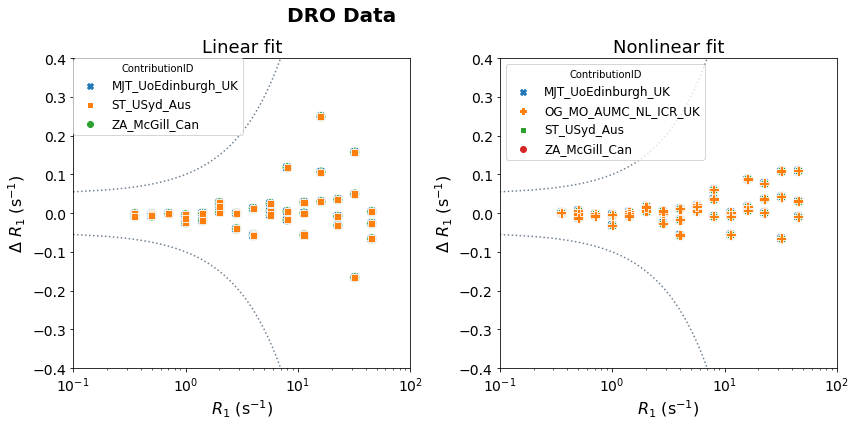

In [25]:
# Test the function, redo the DRO Data
plotPair(
    data_linear=df[(df['source']=='DRO') & (df['method']=='linear')],
    data_nonlinear=df[(df['source']=='DRO') & (df['method']=='nonlinear')],
    xlim=[10**-1,10**2],
    ylim=[-0.4, 0.4],
    suptitle='DRO Data'
)

The next step was to calculate statistics on the error with respect to the reference values. 
For this purpose, we calculated bias and the limits of agreement for each contribution separately according to Bland-Altman statistics (Bland-Altman Stats Med 1999). As can be observed from the figures above, the error in R1 increases with increasing magnitude of the reference values (i.e. error is larger for large R1 values). This was taken into account by calculating the percentage difference (perc_error = (meas-ref)/ref*100). Mean and LoA were calculated from these percentage differences.

In [8]:
data_linear=df[(df['source']=='DRO') & (df['method']=='linear')]
resultsBA_linear=bland_altman_statistics(data=data_linear,par='perc_error',grouptag='author')

print('Bias results for DRO data for linear implementations of R_1 estimation')
print('note that results are presented as the percentage error')
print(resultsBA_linear)

Bias results for DRO data for linear implementations of R_1 estimation
note that results are presented as the percentage error
                       bias     stdev  LoA lower  LoA upper
author                                                     
MJT_UoEdinburgh_UK -0.25304  0.889515   -1.99649    1.49041
ST_USyd_Aus        -0.25304  0.889515   -1.99649    1.49041
ZA_McGill_Can      -0.25304  0.889515   -1.99649    1.49041


In [9]:
# same for nonlinear data
data_nonlinear=df[(df['source']=='DRO') & (df['method']=='nonlinear')]
resultsBA_nonlinear=bland_altman_statistics(data=data_nonlinear,par='perc_error',grouptag='author')

print('Bias results for DRO data for nonlinear implementations of R_1 estimation')
print('note that results are presented as the percentage error')
print(resultsBA_nonlinear)


Bias results for DRO data for nonlinear implementations of R_1 estimation
note that results are presented as the percentage error
                          bias     stdev  LoA lower  LoA upper
author                                                        
MJT_UoEdinburgh_UK   -0.098617  0.785471  -1.638141   1.440906
OG_MO_AUMC_NL_ICR_UK -0.098617  0.785472  -1.638142   1.440907
ST_USyd_Aus          -0.098616  0.785472  -1.638141   1.440908
ZA_McGill_Can        -0.098625  0.785493  -1.638191   1.440941


## In-vivo data

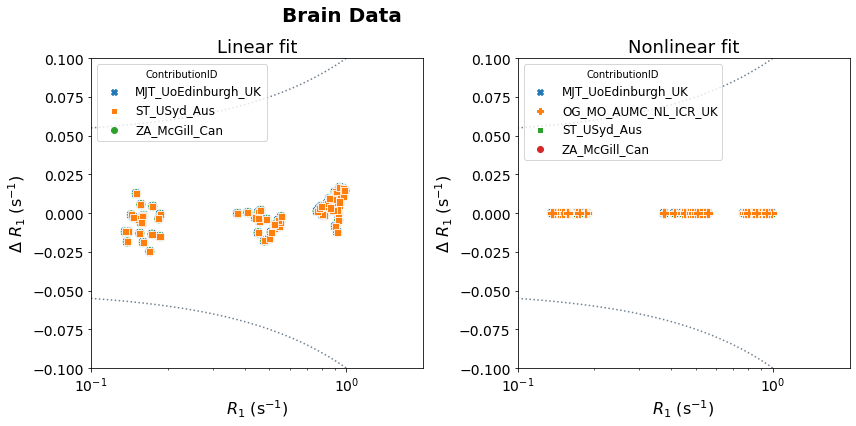

In [27]:
# in-vivo brain data
# Adjust the xlim, ylim if necessary
plotPair(
    data_linear=df[(df['source']=='brain') & (df['method']=='linear')],
    data_nonlinear=df[(df['source']=='brain') & (df['method']=='nonlinear')],
    xlim=[10**-1,10**0.3],
    ylim=[-0.1, 0.1],
    suptitle='Brain Data'
)



Similarly as the DRO data, bias and LoA were calculated for the percentage difference between measured and reference values.

In [11]:
# bland-altman statistics
resultsBA_linear_brain=bland_altman_statistics(data=df[(df['source']=='brain') & (df['method']=='linear')],par='perc_error',grouptag='author')
resultsBA_nonlinear_brain=bland_altman_statistics(data=df[(df['source']=='brain') & (df['method']=='nonlinear')],par='perc_error',grouptag='author')
print('Bias results for brain data for linear implementations of R_1 estimation')
print(resultsBA_linear_brain)
print('Bias results for brain data for nonlinear implementations of R_1 estimation')
print(resultsBA_nonlinear_brain)

Bias results for brain data for linear implementations of R_1 estimation
                        bias     stdev  LoA lower  LoA upper
author                                                      
MJT_UoEdinburgh_UK -1.159407  3.664096  -8.341035   6.022222
ST_USyd_Aus        -1.159407  3.664096  -8.341036   6.022222
ZA_McGill_Can      -1.159407  3.664096  -8.341035   6.022222
Bias results for brain data for nonlinear implementations of R_1 estimation
                          bias     stdev  LoA lower  LoA upper
author                                                        
MJT_UoEdinburgh_UK    0.000245  0.000843  -0.001407   0.001897
OG_MO_AUMC_NL_ICR_UK  0.000245  0.000843  -0.001408   0.001898
ST_USyd_Aus           0.000238  0.000837  -0.001404   0.001879
ZA_McGill_Can         0.000304  0.001193  -0.002035   0.002643


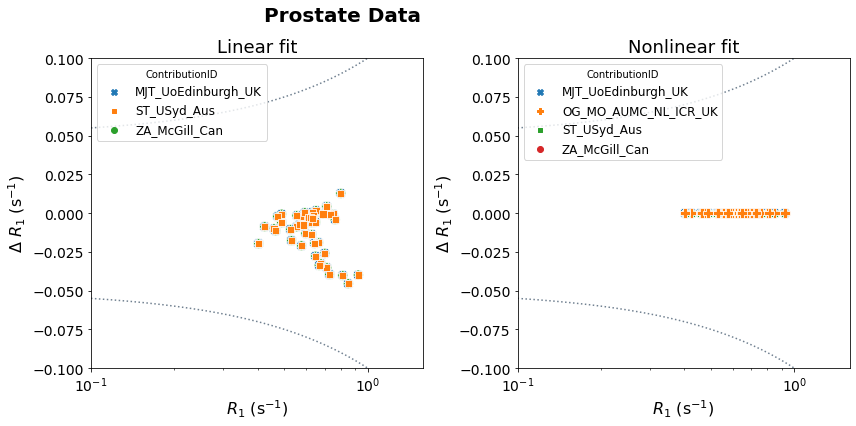

In [28]:
# In-vivo prostate data
# Adjust the xlim, ylim if necessary
plotPair(
    data_linear=df[(df['source']=='prostate') & (df['method']=='linear')],
    data_nonlinear=df[(df['source']=='prostate') & (df['method']=='nonlinear')],
    xlim=[10**-1,10**0.2],
    ylim=[-0.1, 0.1],
    suptitle='Prostate Data'
)

In [13]:
# bland-altman statistics
resultsBA_linear_prostate=bland_altman_statistics(data=df[(df['source']=='prostate') & (df['method']=='linear')],par='perc_error',grouptag='author')
resultsBA_nonlinear_prostate=bland_altman_statistics(data=df[(df['source']=='prostate') & (df['method']=='nonlinear')],par='perc_error',grouptag='author')
print('Bias results for prostate data for linear implementations of R_1 estimation')
print(resultsBA_linear_brain)
print('Bias results for brain data for nonlinear implementations of R_1 estimation')
print(resultsBA_nonlinear_brain)

Bias results for prostate data for linear implementations of R_1 estimation
                        bias     stdev  LoA lower  LoA upper
author                                                      
MJT_UoEdinburgh_UK -1.159407  3.664096  -8.341035   6.022222
ST_USyd_Aus        -1.159407  3.664096  -8.341036   6.022222
ZA_McGill_Can      -1.159407  3.664096  -8.341035   6.022222
Bias results for brain data for nonlinear implementations of R_1 estimation
                          bias     stdev  LoA lower  LoA upper
author                                                        
MJT_UoEdinburgh_UK    0.000245  0.000843  -0.001407   0.001897
OG_MO_AUMC_NL_ICR_UK  0.000245  0.000843  -0.001408   0.001898
ST_USyd_Aus           0.000238  0.000837  -0.001404   0.001879
ZA_McGill_Can         0.000304  0.001193  -0.002035   0.002643


## Notes
The contribtutions that use two flip angles (n = 2) have not been added to the test results yet.

### References

Bland JM and Altman DG "Measuring agreement in method comparison studies" Statistical Methods in Medical Research 1999; 8: 135-160
